In [1]:
# Packages for interfacing with the Google Sheets API. 
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import networkx as nx 
import matplotlib.pyplot as plt 

In [2]:
# Packages for creating and displaying the graph. 
import networkx as nx 
import matplotlib.pyplot as plt 
from time import sleep

In [20]:
class CYOAGame: 
    def __init__(self, script_id, script_data_ranges, start_node_name):
        """
        """
        self.script_id = script_id 
        self.script_data_ranges = script_data_ranges
        self.curr_node_name = start_node_name 
        self.score_keeper = dict()
        
        
    def import_game_data(self):
        """
        This function interfaces with the Google Sheets API to get all the information 
        necessary for creating a script. 
        
        This is helper code taken directly from the documentation on the Sheets API page.
        Attribution: https://developers.google.com/sheets/api/quickstart/python.
        
        Inputs: None. 
        Outputs: The data to generate the storyline graph. 
        """
        
        creds = None 
    
        if os.path.exists('token.pickle'):
            with open('token.pickle', 'rb') as token:
                creds = pickle.load(token)

        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())
            else: 
                flow = InstalledAppFlow.from_client_secrets_file(
                    'credentials.json', SCOPES)
                creds = flow.run_local_server()
                
            # Save the credentials for the next run
            with open('token.pickle', 'wb') as token:
                pickle.dump(creds, token)
                
        #Call the sheets API
        service = build('sheets', 'v4', credentials=creds)
        request = service.spreadsheets().values().batchGet(spreadsheetId=self.script_id, 
                                                           ranges=self.script_data_ranges).execute()
        
        return request['valueRanges']
        
    
    def setup_game_graph(self, game_data): 
        """
        This function sets up the storyline graph 
        based on the data imported. 
        
        Inputs: The data to generate the storyline graph. 
        Outputs: The storyline graph. 
        """
        
        game_graph = nx.DiGraph()
        unaccounted_data = []
        
        for datum in game_data: 
            
            # The first three if/elif statement process each type of node. 
            # Each node is added into the network's node dictionary such that 
                # the name of a situation is the key and its attributes the values. 
            if datum['values'][0][0] == "connector": 
                for row in datum['values'][1:]:
                    game_graph.add_node(row[1],
                                        description=row[2],
                                        num_responses=int(row[3]),
                                        node_type="connector",
                                        choices=dict())
                    

            elif datum['values'][0][0] == "independent situation": 
                 for row in datum['values'][1:]:
                    game_graph.add_node(row[1],
                                        description=row[2],
                                        num_responses=int(row[3]),
                                        node_type="independent situation",
                                        choices=dict())
            
            elif datum['values'][0][0] == "repository": 
                for row in datum['values'][1:]: 
                    game_graph.add_node(row[2],
                                        description=row[4],
                                        num_responses=int(row[5]),
                                        node_type="dependent situation",
                                        choices=dict(),
                                        level=row[1])
            
            # The dependency matrix is created by zipping the list of independent situation nodes
            # and the dependency specification, which is then converted into a dictionary that 
            # gets assigned to a key representing the level. 
            
            elif datum['values'][0][0] == "dependency matrix": 
                dependency_matrix_keys = datum['values'][0][1:]
                self.dependency_matrix = {row[0]:dict(zip(dependency_matrix_keys,row[1:])) for row in datum['values'][1:]}
                
                
            # Choices are add 
            elif datum['values'][0][0] == "choice":
                i = 1
                for row in datum['values']:
                    game_graph.node[row[1]]['choices'].update({i:{'name': str(row[2]),
                                                                            'description':str(row[3]),
                                                                            'score':float(row[4]),
                                                                                'pro':str(row[5]),
                                                                                'con':str(row[6])}})
                    i += 1 
                    
            elif datum['values'][0][0] == "connector choice":
                i = 1 
                for row in datum['values']:
                    game_graph.node[row[1]]['choices'].update({i:{'name': str(row[2]),
                                                                'description':str(row[3]),
                                                                'score': float(row[4])}})
                    i += 1 
                
            elif datum['values'][0][0] == "relationship tracker": 
                for row in datum['values'][1:]:
                    game_graph.add_edge(row[1],
                                        row[2],
                                        threshold=row[3])
                    
            elif datum['values'][0][0] == "node directory": 
                self.node_directory = datum['values']
                
            else: 
                unaccounted_data.append(datum)
            
                
        if unaccounted_data: 
            raise Exception("The graph generated is incompleted and here is the information that needs to be accounted for."
                            ,unaccounted_data)
            
        nx.draw(game_graph, pos=nx.kamada_kawai_layout(game_graph), with_labels=True)
        
        return nx.freeze(game_graph) 
    
        
    def play(self, graph):     
        """
        This method executes the main game loop by 
        displaying situations and asking choices until 
        there isno possible path forward. 
        
        Input: The storyline graph. 
        Output: 
        """
        # Game continues while the current node has outgoing edges.
        
        while graph.out_degree[self.curr_node_name] > 0:  
            
            # Display the text related to the situation and the possible choices. 
            print(graph.node[self.curr_node_name]["description"]) 
            
            sleep(0.5)
            
            choice_keys = graph.node[self.curr_node_name]["choices"].keys()
            for choice_key in choice_keys:
                print("Option {}: ".format(choice_key), 
                                           graph.node[self.curr_node_name]["choices"][choice_key]["description"])
                sleep(0.3)
                     
            # Validate user's responses. 
            while True: 
                try:
                    player_choices = [int(choice_id) for choice_id in input("Indicate your choices: ").split(",")]
                except ValueError: 
                    print ("Remember to choose a number.")
                    continue
         
                if not len(list(player_choices)) == graph.node[self.curr_node_name]['num_responses']:
                    if len(list(player_choices)) > graph.node[self.curr_node_name]['num_responses']:
                        print("You have entered more choices than allowed. Please renter your choice.")
                        continue
                    else: 
                        print("You have entered less choices than allowed. Please renter your choice.")
                        continue
    
                try:
                    for choice in player_choices: 
                        c = graph.node[self.curr_node_name]["choices"][choice]

                except KeyError: 
                    print("Key doesn't exist")
                    continue 
                        
                    
                break


                    
            # Calculate score for player's choice and add to the score keeper. 
            score = 0 
            for choice in player_choices: 
                score += graph.node[self.curr_node_name]["choices"][choice]["score"]
                
            self.score_keeper[self.curr_node_name] = score

            
            # Determine which node to go to next. 
            outgoing_neighbors = list(graph.adj[self.curr_node_name].keys())
            print("Outgoing neighbors are", outgoing_neighbors)

            if len(outgoing_neighbors) == 1: 
                next_node_name = list(graph.adj[self.curr_node_name].keys())[0]
                self.curr_node_name = next_node_name

            else: 
                ### THIS IS WHERE I AM WORKING RNNNNN 
                threshold_key = 0 
                thresholds = []

                for neighbor in outgoing_neighbors:
                    # Keep track of thresholds for each edge. 
                    neighbor_threshold = graph.get_edge_data(self.curr_node_name, neighbor)["threshold"]
                    thresholds.append((neighbor, float(neighbor_threshold)))
                    neighbor_level = graph.node[neighbor]["level"]

                    # Determine threshold level and calculate threshold keys for the specific levels. 
                    for dep_key, dep_value in self.dependency_matrix[neighbor_level].items(): 
                        if dep_value != 0: 
                            threshold_key += self.score_keeper[dep_key] * float(dep_value)

                threshold_key = threshold_key/len(player_choices)
                print("threshold key for the current level is", threshold_key)

                # Find the value which is closest to in the threshold.

                next_node_name = None 
                print("the next node name is",next_node_name)
                min_dist = None
                print("the min dist when we begin is", min_dist)
                for t in range(len(thresholds)): 
                    if min_dist is None or min_dist > abs(thresholds[t][1] - threshold_key):
                        min_dist = abs(thresholds[t][1] - threshold_key)
                        print("the min dist is now", min_dist)
                        next_node_name = thresholds[t][0]

                        print("the current next node name is", next_node_name)
                print("the current node goes from being", self.curr_node_name)


                self.curr_node_name = next_node_name
                print(self.curr_node_name)


        sleep(0.8)
        
                    
        return ("Thank you for playing!")     

In [21]:
SCRIPT_SHEET_ID = "10OTyaFnp_ERkAKL0mBfaAuANuM1rzgnxCf9JjyP5IR8"
SCRIPT_RANGES =["'node directory'!A1:C16",
               "'node relationships'!A1:D18",
                "'connector nodes'!A1:D4", 
               "'all choices'!A2:G3",
                "'all choices'!A5:G5",
               "'all choices'!A7:G7",
               "'independent situations nodes'!A1:D6",
               "'all choices'!A9:H10", 
                "'all choices'!A12:G13", 
                "'all choices'!A15:G16",
                "'all choices'!A18:G19",
                "'all choices'!A21:G22",
               "'dependency matrix'!A1:F3",
               "'situation repository'!A1:F8", 
                "'all choices'!A24:G26", 
               "'all choices'!A28:G30",
               "'all choices'!A32:G34", 
               "'all choices'!A36:G38", 
               "'all choices'!A40:G42",
               "'all choices'!A44:G46",
               "'all choices'!A48:G50"]

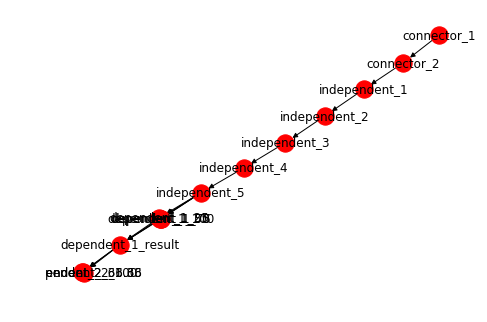

In [22]:
game = CYOAGame(SCRIPT_SHEET_ID,SCRIPT_RANGES, "connector_1")
game_graph = game.setup_game_graph(game.import_game_data())

In [ ]:
game.play(game_graph)